In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import plotly.io as pio
import polars as pl
from icecream import ic
from ipywidgets import interact
from polars import col
from scipy import signal

from src.data.database_manager import DatabaseManager
from src.data.quality_checks import check_sample_rate
from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.features.eeg import (
    decimate_eeg,
    highpass_filter_eeg,
    preprocess_eeg,
    remove_line_noise,
)
from src.features.labels import add_labels, process_labels
from src.features.resampling import decimate
from src.features.scaling import scale_min_max
from src.features.transforming import map_trials, merge_dfs
from src.features.utils import add_time_column
from src.log_config import configure_logging
from src.plots.plot_modality import plot_modality_over_trials
from src.plots.utils import prepare_multiline_hvplot

logger = logging.getLogger(__name__.rsplit(".", 1)[-1])

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)
mne.set_log_level(verbose=None, return_old_level=False, add_frames=None)

In [3]:
# Goal: aggregated EEG time frequency data across Trials x Channels (12 * 8)

In [4]:
def plot_psd_df(
    df: pl.DataFrame,
    channel: str = "c4",
    fs: int = 500,
):
    data = df.get_column(channel).to_numpy()
    plt.psd(data, Fs=fs)
    plt.title(f"Power Spectral Density of {channel}")


In [5]:
db = DatabaseManager()

In [6]:
eeg_query = """
SELECT * 
FROM Raw_EEG
WHERE trial_id < 60
"""
trial_query = """
SELECT *
FROM Trials
WHERE trial_id < 60
"""
with db:
    eeg = db.execute(eeg_query).pl()
    trials = db.execute(trial_query).pl()

df = merge_dfs(
    dfs=[eeg, trials],
    on=[
        "trial_id",
        "participant_id",
        "trial_number",
    ],
).drop("timestamp_start", "timestamp_end", "duration")
df

shape: (5_310_433, 15)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ trial_id ┆ trial_num ┆ participa ┆ rownumber ┆ … ┆ p4        ┆ oz        ┆ stimulus_ ┆ skin_area │
│ ---      ┆ ber       ┆ nt_id     ┆ ---       ┆   ┆ ---       ┆ ---       ┆ seed      ┆ ---       │
│ u16      ┆ ---       ┆ ---       ┆ u32       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ u8        │
│          ┆ u8        ┆ u8        ┆           ┆   ┆           ┆           ┆ u16       ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1        ┆ 1         ┆ 1         ┆ 147086    ┆ … ┆ 13553.095 ┆ 5451.5361 ┆ 396       ┆ 1         │
│          ┆           ┆           ┆           ┆   ┆ 703       ┆ 33        ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 147087    ┆ … ┆ 13557.387 ┆ 5453.3007 ┆ 396       ┆ 1         │
│          ┆           ┆           ┆           ┆   ┆ 695       ┆ 81        ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 147088    ┆ … ┆ 13561.726 ┆ 5462.0742 ┆ 396       ┆ 1         │
│          ┆           ┆           ┆           ┆   ┆ 562       ┆ 19        ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 147089    ┆ … ┆ 13567.115 ┆ 5467.7011 ┆ 396       ┆ 1         │
│          ┆           ┆           ┆           ┆   ┆ 234       ┆ 72        ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 147090    ┆ … ┆ 13552.333 ┆ 5452.8242 ┆ 396       ┆ 1         │
│          ┆           ┆           ┆           ┆   ┆ 008       ┆ 19        ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 147091    ┆ … ┆ 13534.927 ┆ 5438.0419 ┆ 396       ┆ 1         │
│          ┆           ┆           ┆           ┆   ┆ 734       ┆ 92        ┆           ┆           │
│ …        ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 59       ┆ 3         ┆ 6         ┆ 461653    ┆ … ┆ -8265.114 ┆ -12072.13 ┆ 133       ┆ 4         │
│          ┆           ┆           ┆           ┆   ┆ 258       ┆ 4766      ┆           ┆           │
│ 59       ┆ 3         ┆ 6         ┆ 461654    ┆ … ┆ -8264.350 ┆ -12068.60 ┆ 133       ┆ 4         │
│          ┆           ┆           ┆           ┆   ┆ 586       ┆ 6445      ┆           ┆           │
│ 59       ┆ 3         ┆ 6         ┆ 461655    ┆ … ┆ -8274.413 ┆ -12075.56 ┆ 133       ┆ 4         │
│          ┆           ┆           ┆           ┆   ┆ 086       ┆ 8359      ┆           ┆           │
│ 59       ┆ 3         ┆ 6         ┆ 461656    ┆ … ┆ -8269.929 ┆ -12069.51 ┆ 133       ┆ 4         │
│          ┆           ┆           ┆           ┆   ┆ 688       ┆ 1719      ┆           ┆           │
│ 59       ┆ 3         ┆ 6         ┆ 461657    ┆ … ┆ -8267.641 ┆ -12066.60 ┆ 133       ┆ 4         │
│          ┆           ┆           ┆           ┆   ┆ 602       ┆ 3516      ┆           ┆           │
│ 59       ┆ 3         ┆ 6         ┆ 461658    ┆ … ┆ -8272.933 ┆ -12074.28 ┆ 133       ┆ 4         │
│          ┆           ┆           ┆           ┆   ┆ 594       ┆ 125       ┆           ┆           │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [9]:
SAMPLE_RATE = 500
trial_id = 32
decimation_factor = 2
eeg = df.filter(col("trial_id") == trial_id)
decimated = decimate_eeg(eeg, decimation_factor)
SAMPLE_RATE /= decimation_factor
filtered = highpass_filter_eeg(decimated, 0.5, SAMPLE_RATE)
denoised = remove_line_noise(filtered, SAMPLE_RATE)
denoised

Polyphase resampling neighborhood: ±2 input samples
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1651 samples (6.604 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



shape: (45_002, 15)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ trial_id ┆ trial_num ┆ participa ┆ rownumber ┆ … ┆ c4        ┆ p3        ┆ p4        ┆ oz        │
│ ---      ┆ ber       ┆ nt_id     ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ u16      ┆ ---       ┆ ---       ┆ u32       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│          ┆ u8        ┆ u8        ┆           ┆   ┆           ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 32       ┆ 8         ┆ 3         ┆ 888352    ┆ … ┆ -2.0981e- ┆ 1.1395e-1 ┆ -4.9969e- ┆ -2.2169e- │
│          ┆           ┆           ┆           ┆   ┆ 12        ┆ 2         ┆ 12        ┆ 12        │
│ 32       ┆ 8         ┆ 3         ┆ 888354    ┆ … ┆ -4.15928  ┆ -5.927324 ┆ -4.863958 ┆ -8.838347 │
│ 32       ┆ 8         ┆ 3         ┆ 888356    ┆ … ┆ -6.111778 ┆ -9.046792 ┆ -7.587988 ┆ -17.48525 │
│          ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 3         │
│ 32       ┆ 8         ┆ 3         ┆ 888358    ┆ … ┆ -1.773001 ┆ -6.163588 ┆ -4.618937 ┆ -14.66423 │
│          ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 7         │
│ 32       ┆ 8         ┆ 3         ┆ 888360    ┆ … ┆ 2.284116  ┆ -7.526186 ┆ -0.084677 ┆ -9.009547 │
│ 32       ┆ 8         ┆ 3         ┆ 888362    ┆ … ┆ -1.374418 ┆ -10.8784  ┆ -2.75054  ┆ -8.926322 │
│ …        ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 32       ┆ 8         ┆ 3         ┆ 978344    ┆ … ┆ -0.147967 ┆ -7.488573 ┆ -3.099777 ┆ -8.21555  │
│ 32       ┆ 8         ┆ 3         ┆ 978346    ┆ … ┆ -1.115151 ┆ -10.54448 ┆ -2.158589 ┆ -4.499628 │
│          ┆           ┆           ┆           ┆   ┆           ┆ 8         ┆           ┆           │
│ 32       ┆ 8         ┆ 3         ┆ 978348    ┆ … ┆ 2.439389  ┆ -8.33179  ┆ 1.23568   ┆ 2.018375  │
│ 32       ┆ 8         ┆ 3         ┆ 978350    ┆ … ┆ 2.778341  ┆ -5.570706 ┆ 2.876744  ┆ 5.567515  │
│ 32       ┆ 8         ┆ 3         ┆ 978352    ┆ … ┆ 3.575136  ┆ -0.84015  ┆ 3.337055  ┆ 2.85245   │
│ 32       ┆ 8         ┆ 3         ┆ 978354    ┆ … ┆ -6.6574e- ┆ -1.4736e- ┆ -3.8664e- ┆ -1.0011e- │
│          ┆           ┆           ┆           ┆   ┆ 13        ┆ 12        ┆ 12        ┆ 12        │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

841


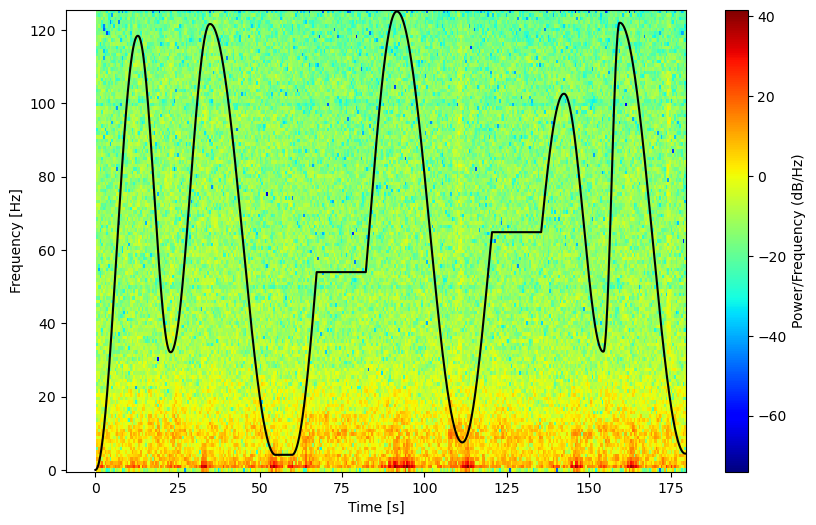

In [12]:
data = denoised.get_column("c4").to_numpy().T

# Create the spectrogram
f, t, Sxx = signal.spectrogram(
    data, fs=SAMPLE_RATE, nperseg=256, noverlap=128, scaling="density"
)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot spectrogram
plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap="jet", shading="auto")

# Get stimulus data
seed = (
    denoised.filter(col("trial_id") == trial_id)
    .get_column("stimulus_seed")
    .unique()
    .item()
)
print(seed)
stimulus = StimulusGenerator(seed=seed)

# Scale the stimulus data to match the frequency range
stimulus_scaled = np.interp(
    stimulus.y, (stimulus.y.min(), stimulus.y.max()), (f.min(), f.max())
)

# Create time points for stimulus that match spectrogram time axis
stimulus_time = np.linspace(0, t[-1], len(stimulus.y))

# Plot the scaled stimulus
plt.plot(stimulus_time, stimulus_scaled, color="black")

plt.colorbar(label="Power/Frequency (dB/Hz)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.show()


Periods: 32 iterations to converge
Amplitudes: 7154 iterations to converge


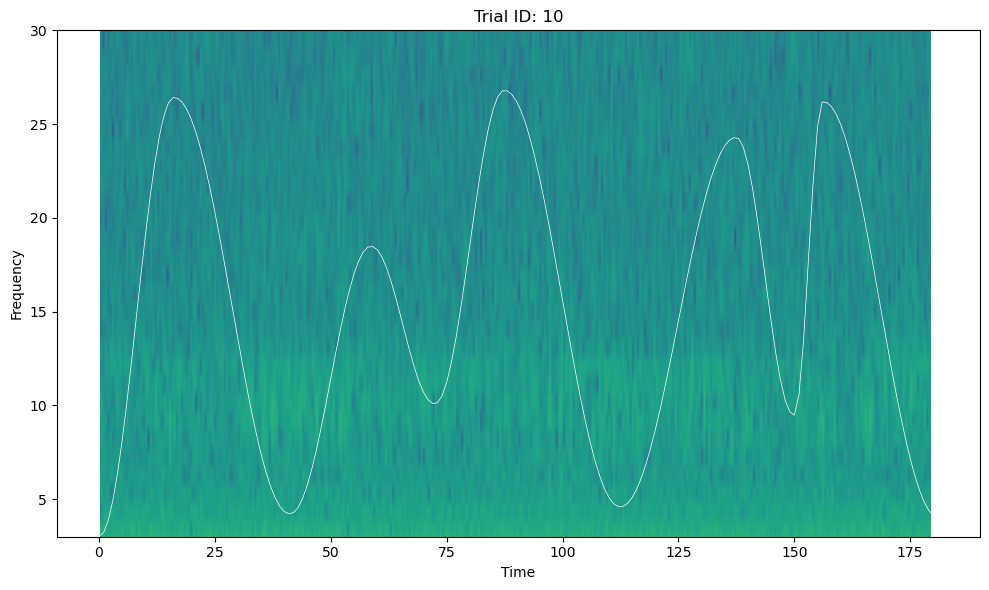

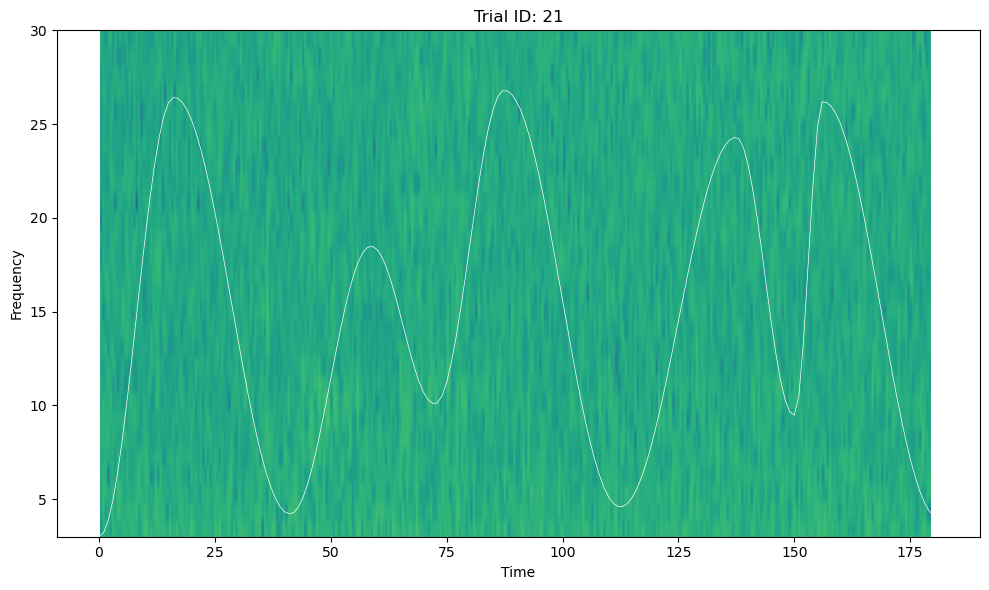

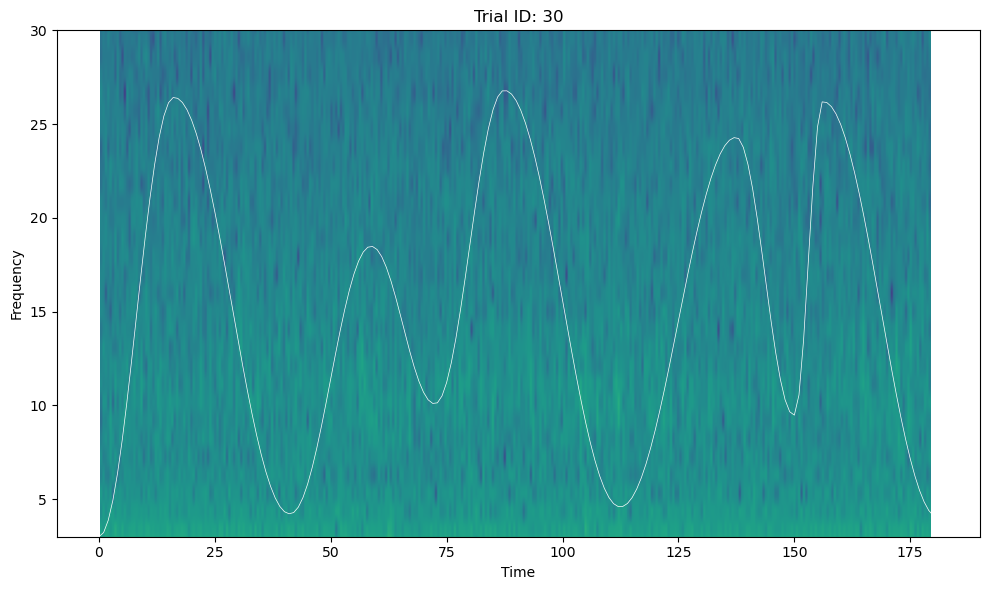

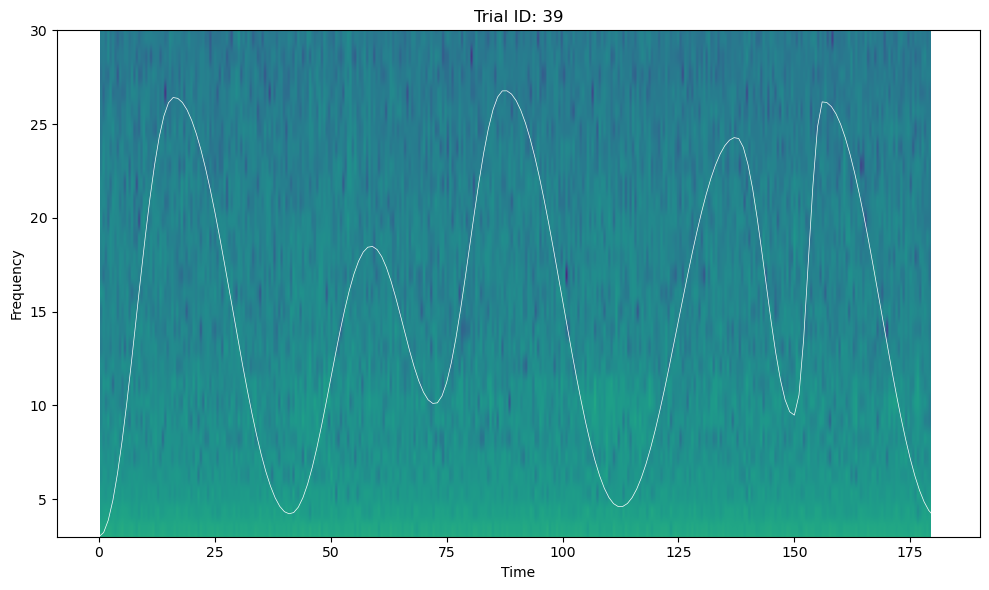

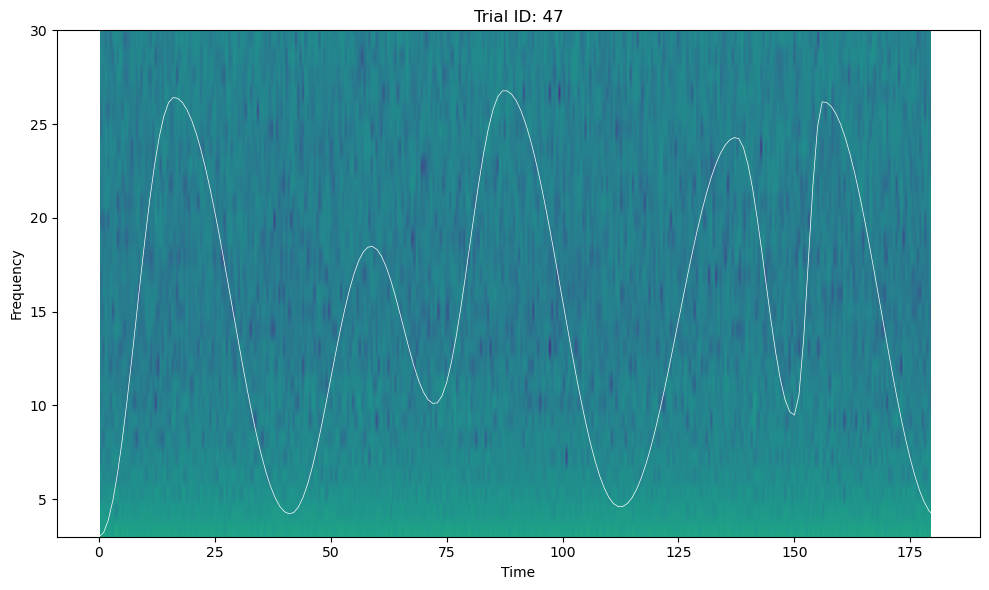

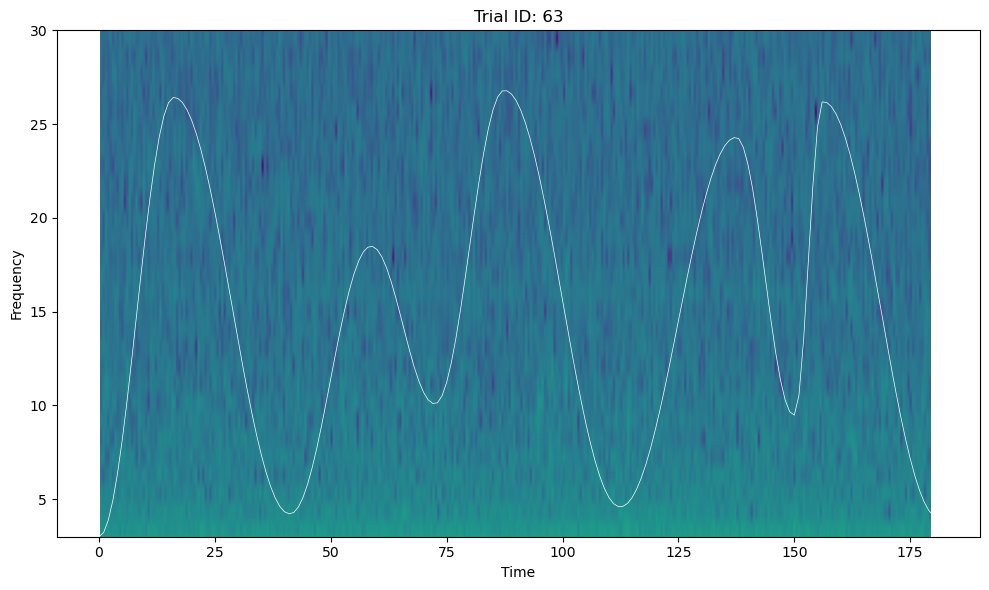

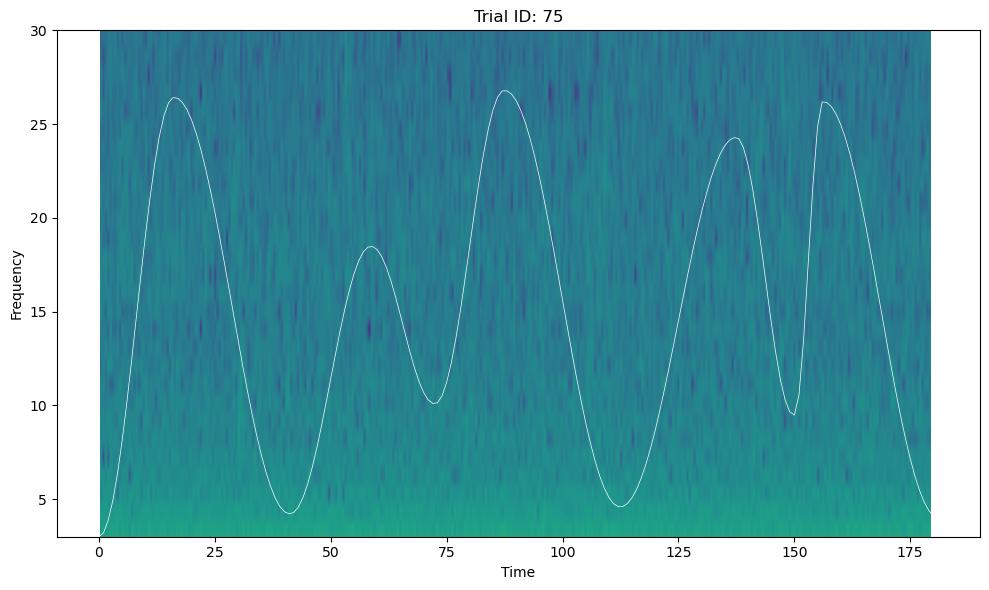

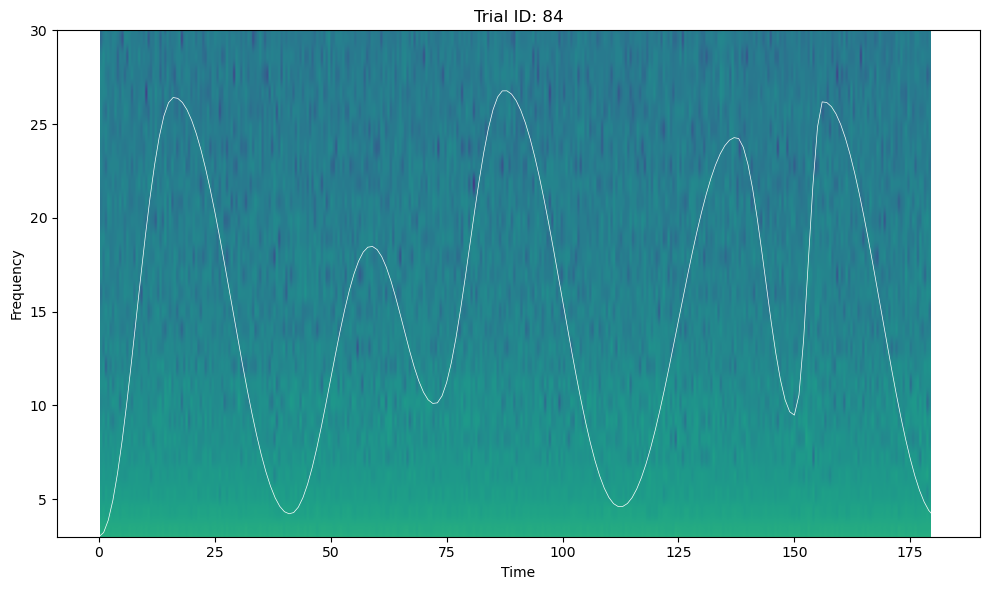

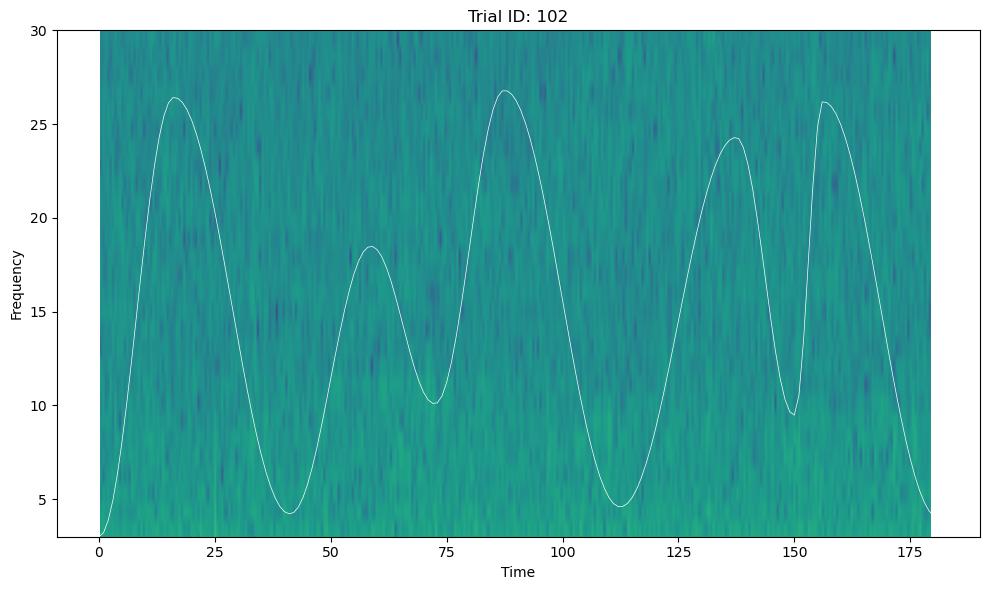

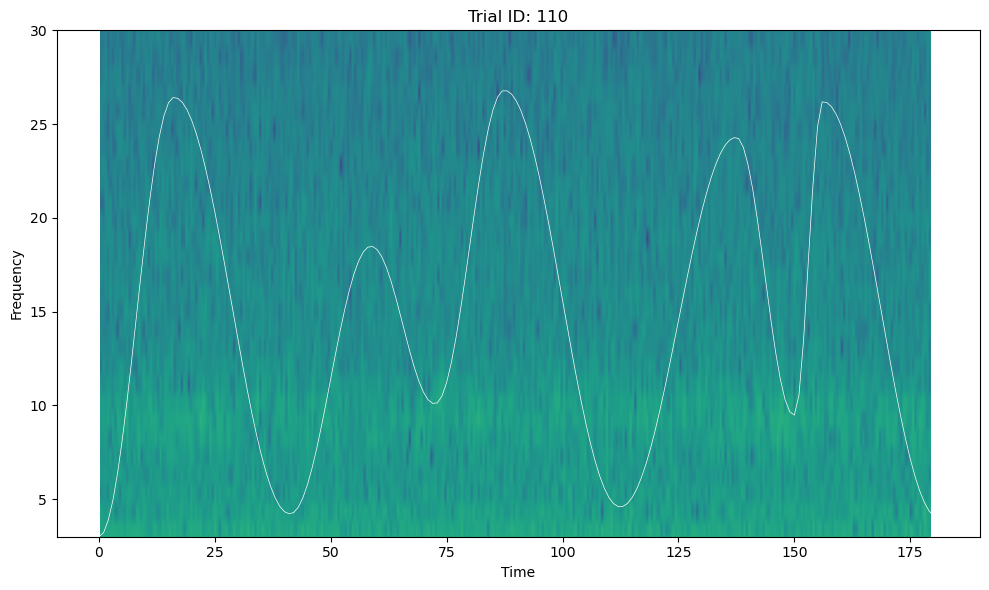

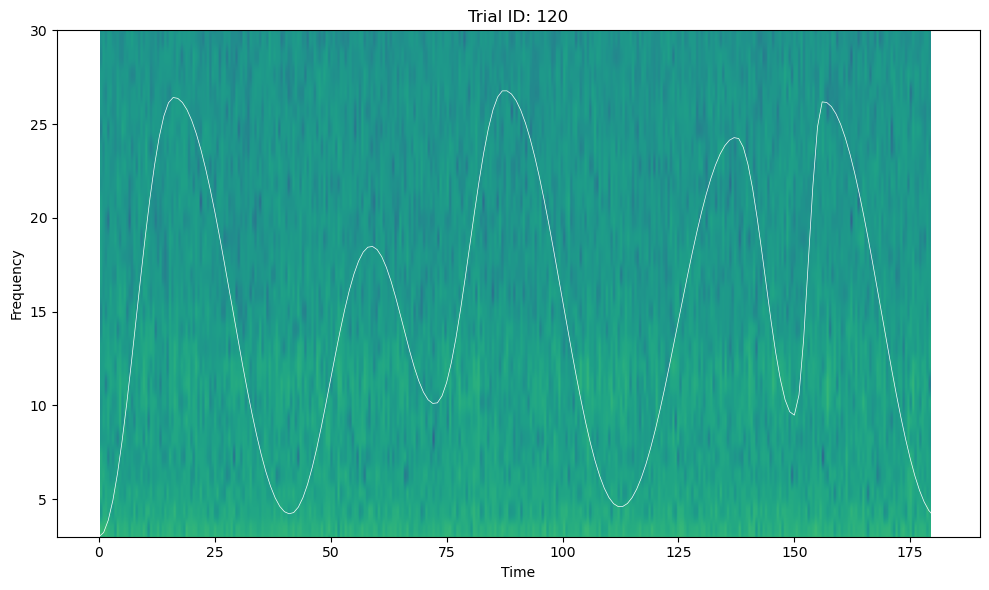

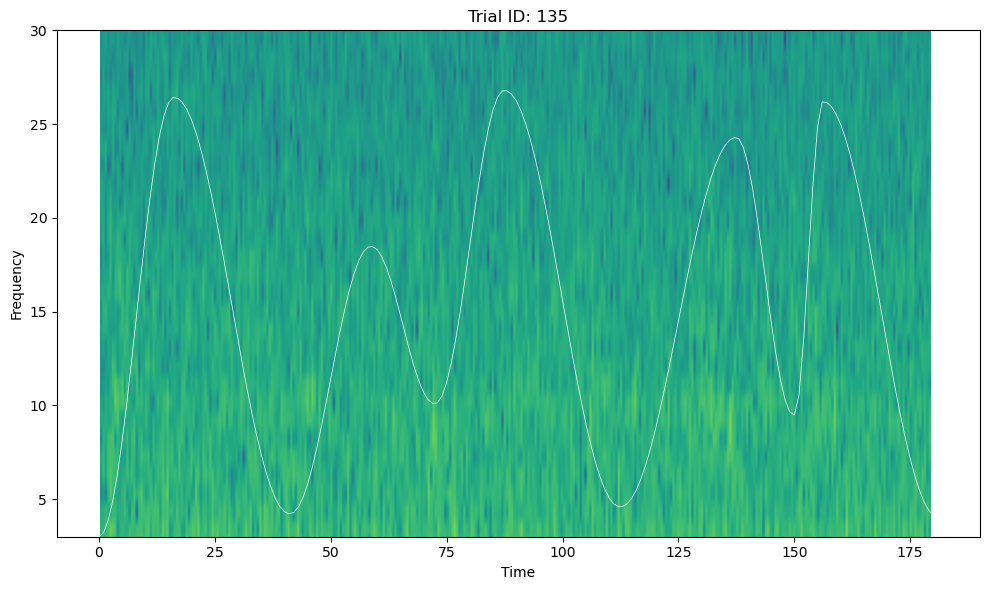

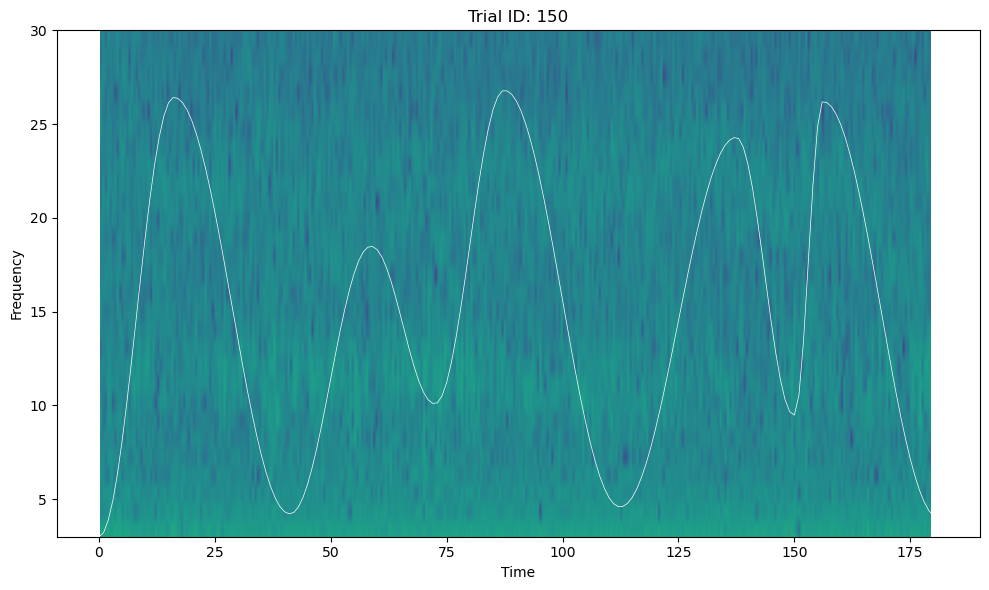

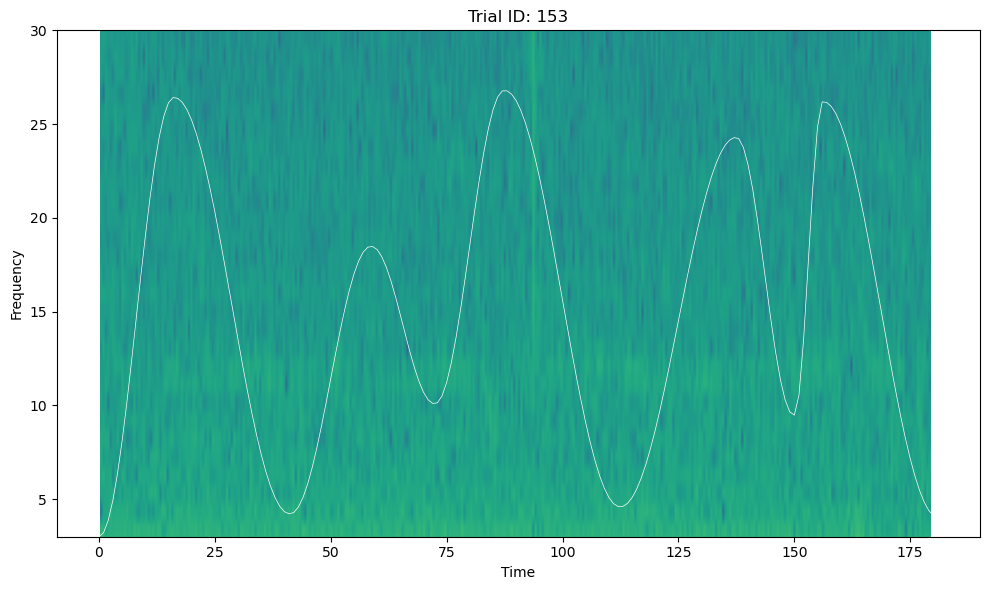

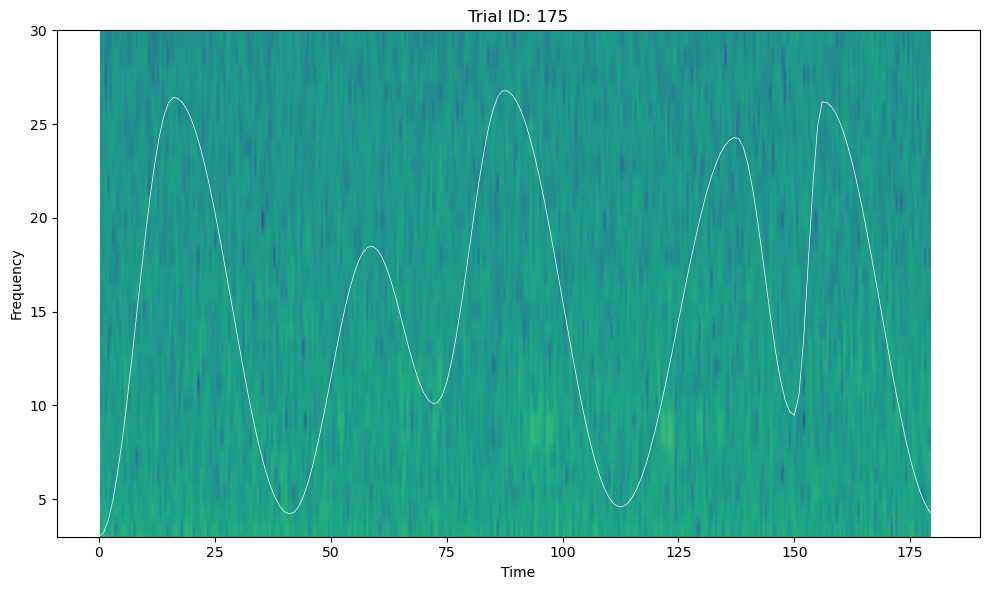

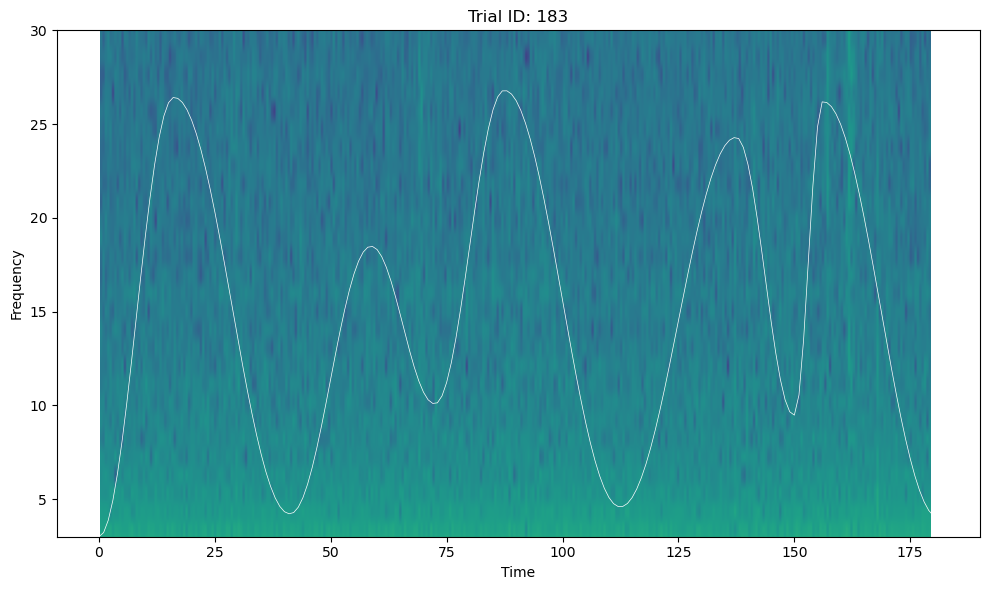

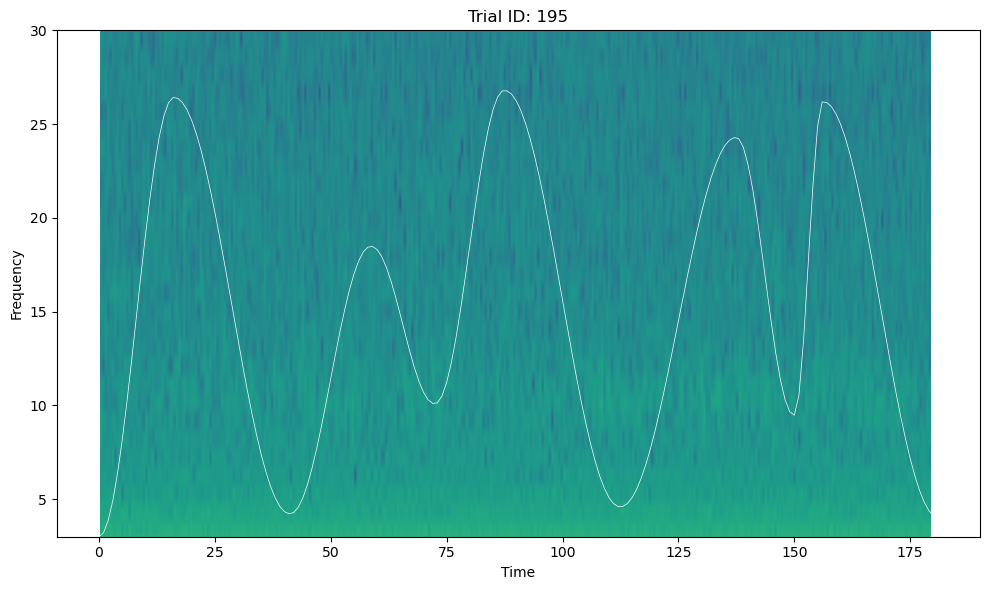

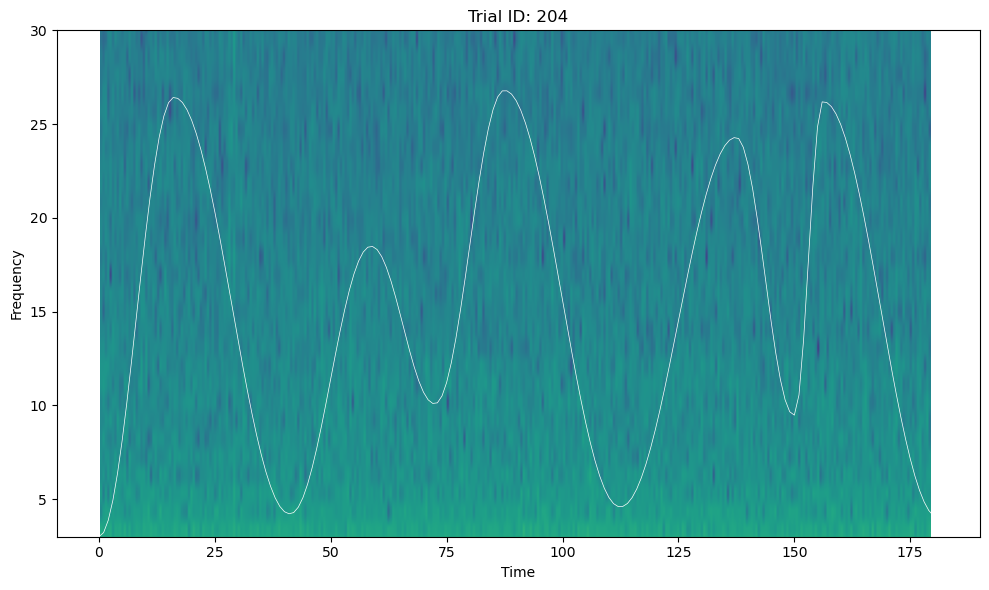

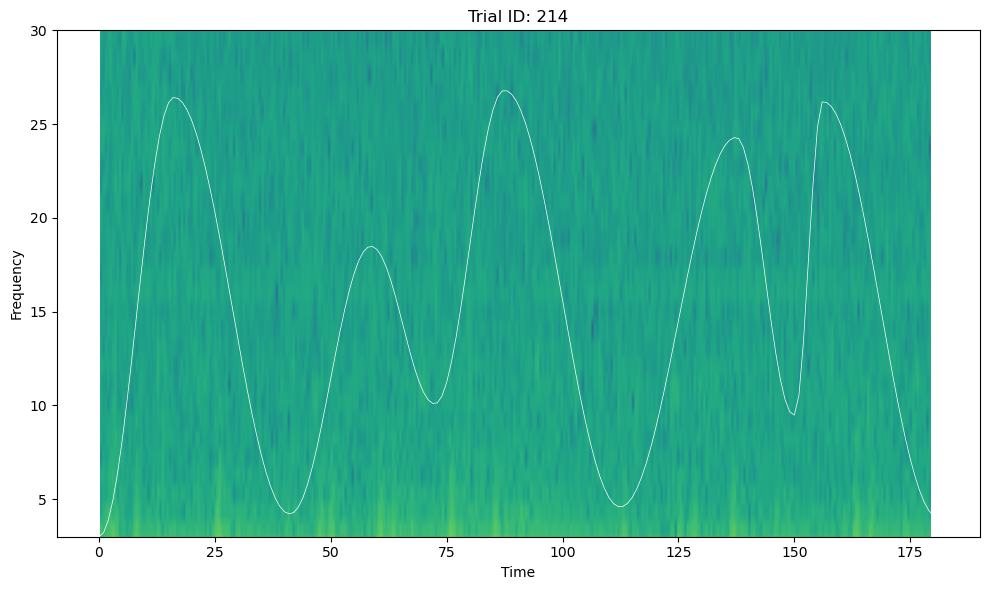

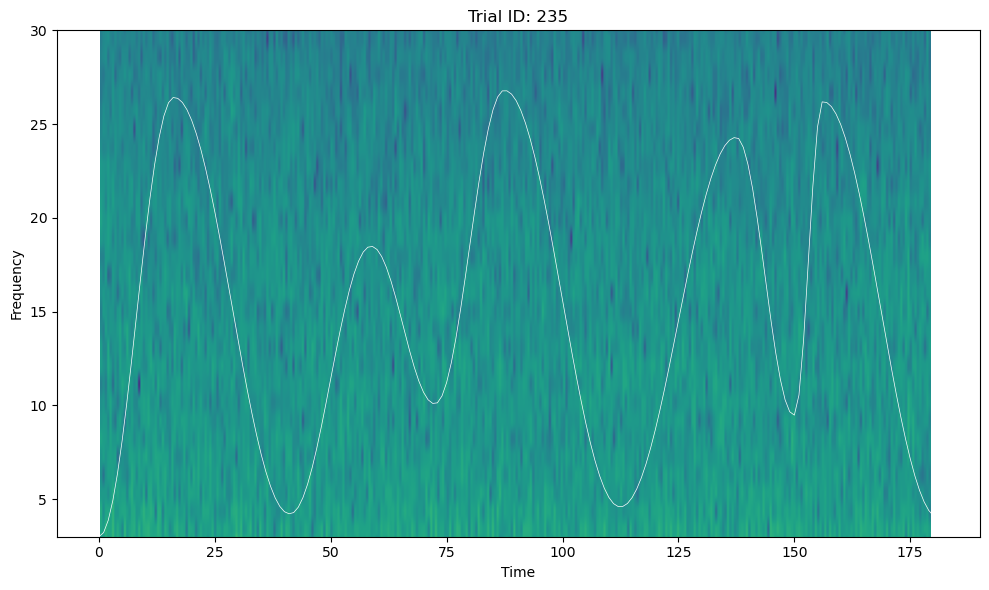

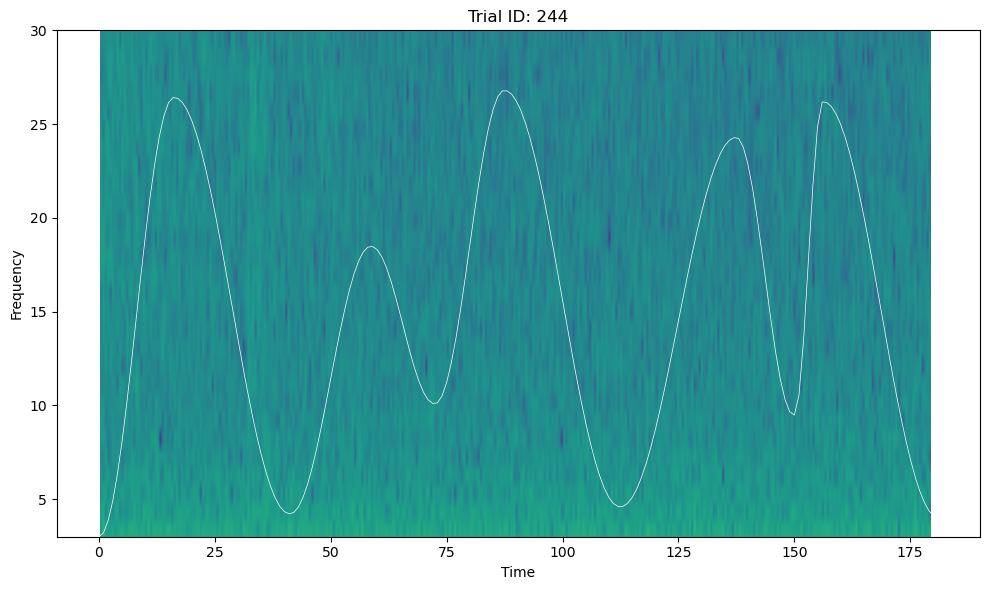

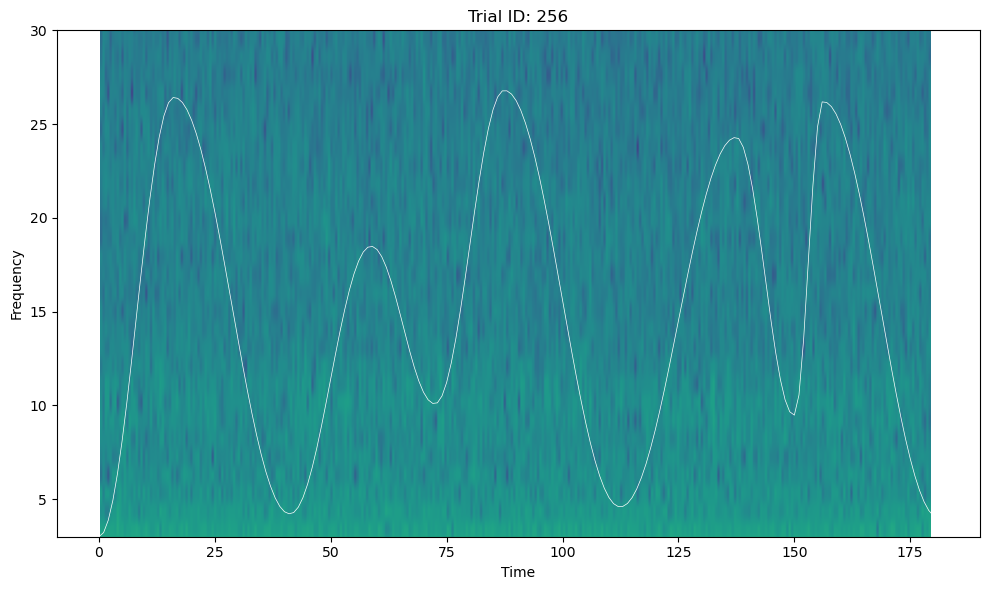

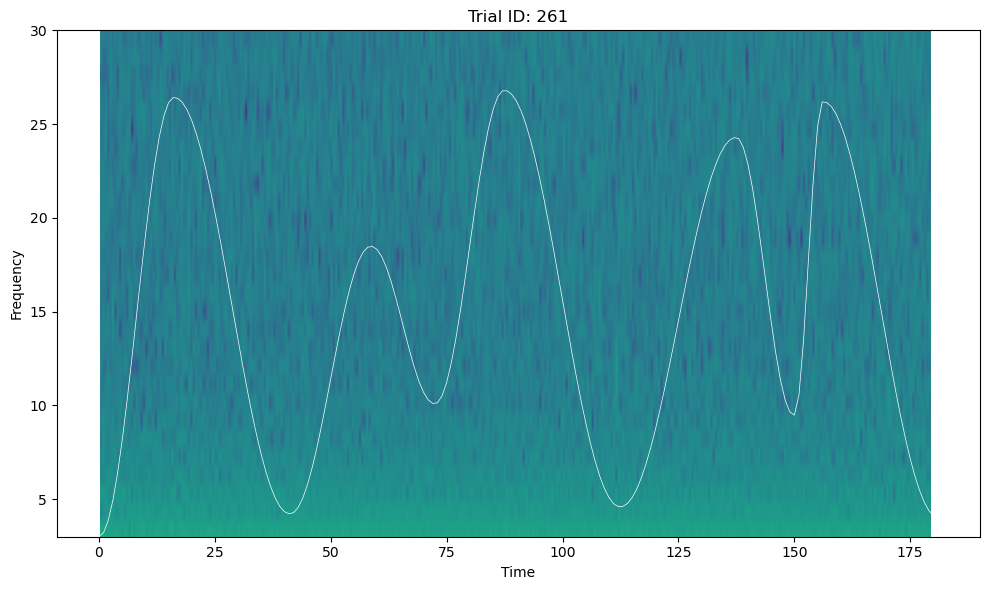

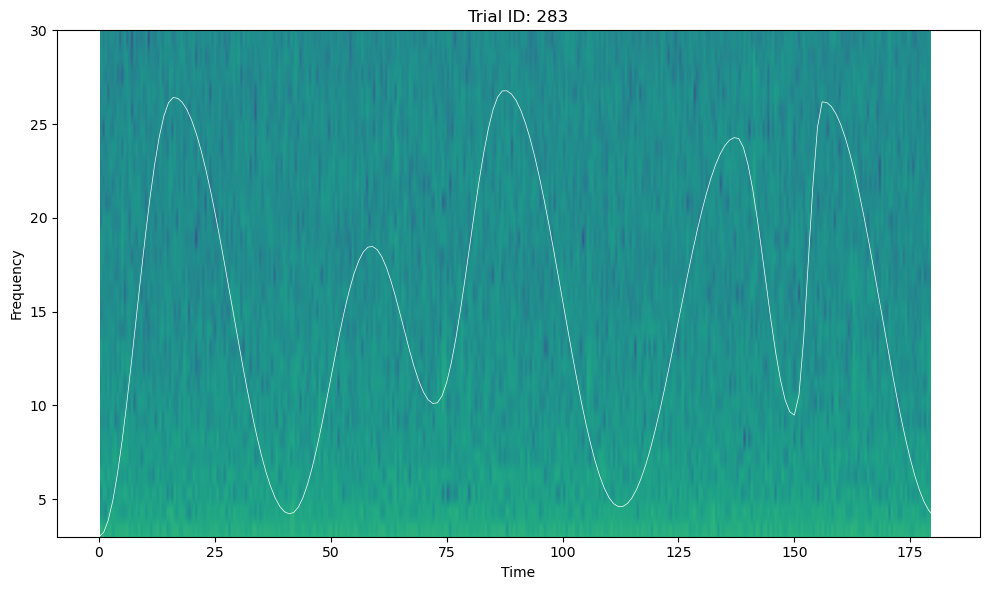

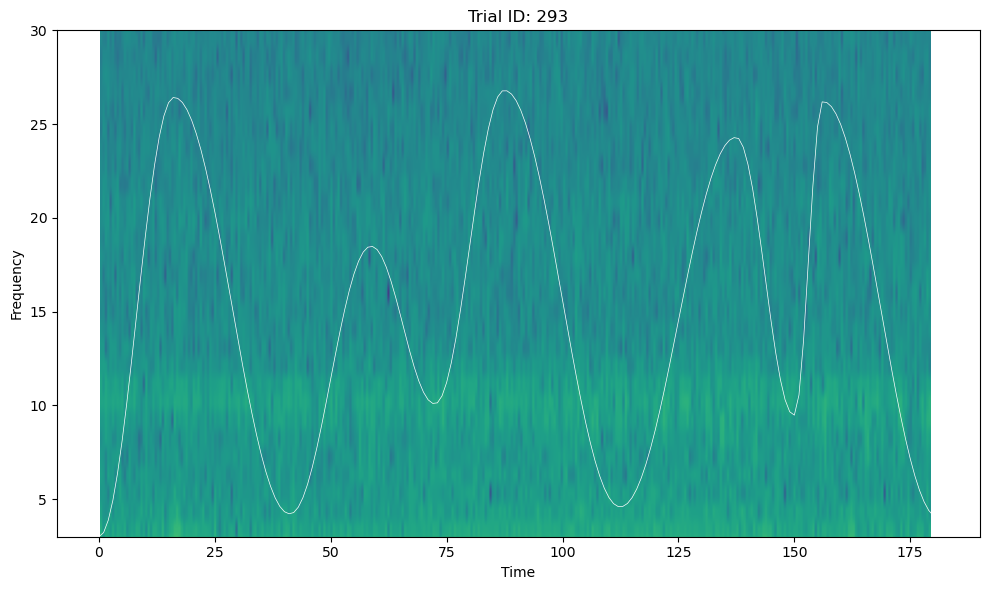

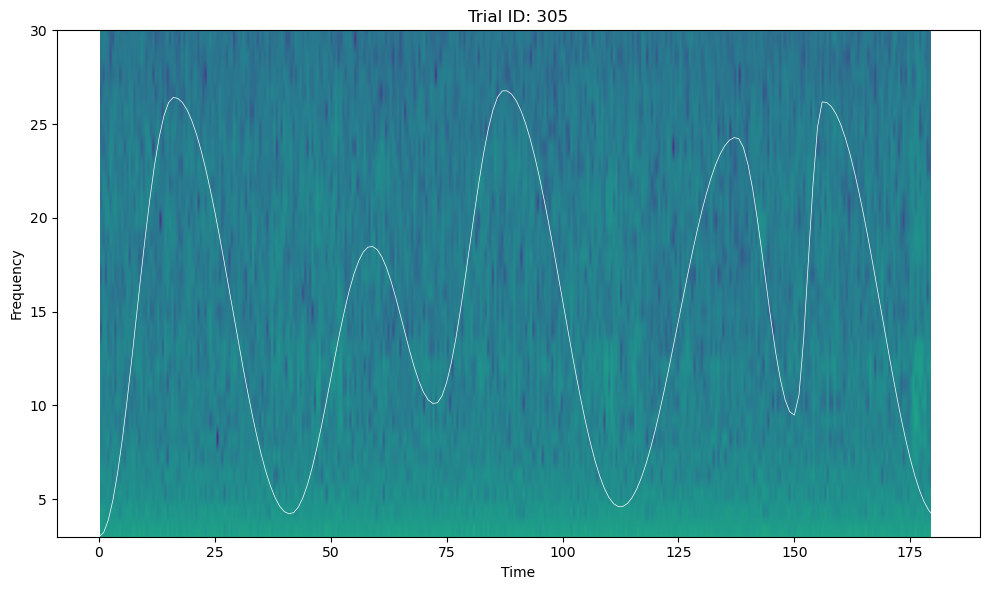

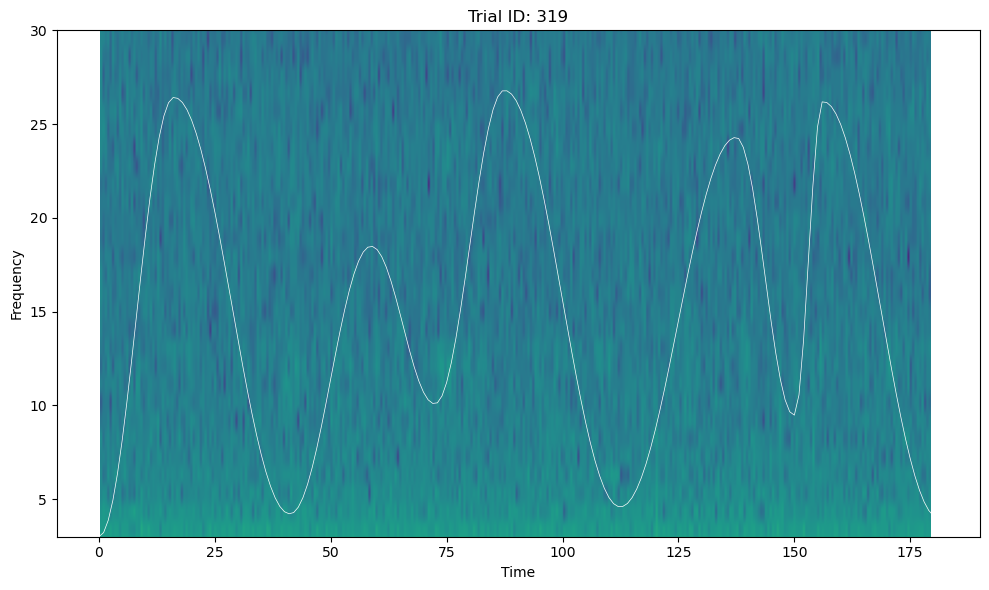

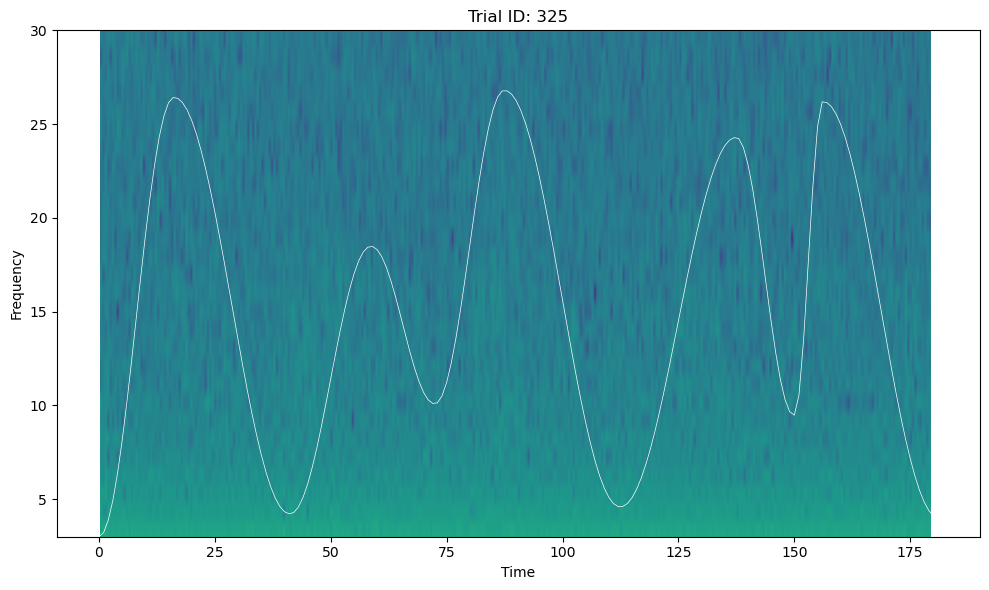

In [ ]:
# Normalizing the data
normalized = (
    decimated.sort(["trial_id"])  # Sort within each group if needed
    .group_by("trial_id", maintain_order=True)
    .agg(
        [
            pl.all().limit(180 * 250)  # Take the first 9000 rows for each group
        ]
    )
    .explode(pl.all().exclude("trial_id"))  # Explode the result back into rows
)
seed = normalized.get_column("stimulus_seed").unique().item()

stim = StimulusGenerator(seed=seed, debug=True)
for _, group in normalized.group_by("trial_id", maintain_order=False):
    data = group.get_column("c4").to_numpy().T

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.specgram(data, Fs=250, NFFT=256, noverlap=128, cmap="viridis")

    plt.plot(stim.y[::8] * 12 + 15, color="white", linewidth=0.5)

    plt.title(f"Trial ID: {group['trial_id'][0]}")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.ylim(3, 30)

    plt.tight_layout()
    plt.show()


In [ ]:
# Normalizing the data
normalized = (
    denoised.sort(["trial_id"])  # Sort within each group if needed
    .group_by("trial_id", maintain_order=True)
    .agg(
        pl.all().limit(180 * 250)  # Take the first 9000 rows for each group
    )
    .explode(pl.all().exclude("trial_id"))  # Explode the result back into rows
)
normalized